In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default = "notebook_connected"
import warnings
warnings.filterwarnings("ignore")

from pyecharts.charts import Bar, Grid, Line, Liquid, Page, Pie, Timeline
from pyecharts import options as opts


pd.options.display.float_format = '{:.2f}'.format
col = px.colors.qualitative.Pastel

In [2]:
act = pd.read_csv('2_act_info.csv')
cus = pd.read_csv('2_cus_info.csv')
iem = pd.read_csv('2_iem_info.csv')
trd_kr =  pd.read_csv('2_trd_kr.csv')
trd_oss =  pd.read_csv('2_trd_oss.csv')
cus = cus.astype({'tco_cus_grd_cd' : 'str'})
trd_kr['orr_dt'] = pd.to_datetime(trd_kr['orr_dt'].astype(str), format='%Y%m%d')
trd_oss['orr_dt'] = pd.to_datetime(trd_oss['orr_dt'].astype(str), format='%Y%m%d')

In [3]:
#연령대 카테고리 추가

cus.loc[(cus['cus_age'] >= 0) & (cus['cus_age'] < 10), 'age_cat'] = '10대 미만'
cus.loc[(cus['cus_age'] >= 10) & (cus['cus_age'] < 20), 'age_cat'] = '10대'
cus.loc[(cus['cus_age'] >= 20) & (cus['cus_age'] < 30), 'age_cat'] = '20대'
cus.loc[(cus['cus_age'] >= 30) & (cus['cus_age'] < 40), 'age_cat'] = '30대'
cus.loc[(cus['cus_age'] >= 40) & (cus['cus_age'] < 50),'age_cat'] = '40대'
cus.loc[(cus['cus_age'] >= 50) & (cus['cus_age'] < 60), 'age_cat'] = '50대'
cus.loc[(cus['cus_age'] >= 60) & (cus['cus_age'] < 70), 'age_cat'] = '60대'
cus.loc[cus['cus_age'] == 70, 'age_cat'] = '70대 이상'

#고객 등급, 투자성향 변수 변경

cus['tco_cus_grd_cd'] = cus['tco_cus_grd_cd'].replace({'01':'01 탑클래스','02':'02 골드','03':'03 로얄','04':'04 그린',
                                                       '05':'05 블루','09':'09 등급없음','_ ':'09 등급없음'})
cus['ivs_icn_cd'] = cus['ivs_icn_cd'].replace({'01':'01 안정형','02':'02 안정추구형','03':'03 위험중립형','04':'04 적극투자형',
                                               '05':'05 공격투자형','09':'09 전문투자자형','00':'정보 제공 미동의',
                                               '_ ':'등급없음', '_':'등급없음','-':'등급없음'})
cus = cus.rename({"sex_dit_cd":"sex", "cus_age":"age", "zip_ctp_cd": "home",
                  "tco_cus_grd_cd":"grade", "ivs_icn_cd":"ivst"},axis='columns')

In [4]:
actcus = pd.merge(act,cus,on='cus_id')
act_cus = actcus[['act_id','cus_id','act_opn_ym']]
act_cus.to_csv('act_cus.csv', index=False) #고객정보와 계좌정보 연결한 데이터

In [5]:
#개인당 국내계좌 개수 추출

count = {}
lists = list(actcus['cus_id'])

for i in lists:
    try: count[i] += 1
    except: count[i]=1
        
a = pd.DataFrame({'cus_id' : list(count.keys()), 
                  'num_act' : list(count.values())})

In [6]:
cus_info = pd.merge(cus, a, on='cus_id') #고객정보 데이터(10000명)

In [7]:
trd_kr = pd.merge(act_cus, trd_kr, on='act_id') #거래-고객 정보 데이터
trd_kr['amount'] = trd_kr['cns_qty']*trd_kr['orr_pr'] #거래별 금액 계산

In [8]:
df = pd.merge(trd_kr, cus_info, how='left', on='cus_id')

In [9]:
df1 = df.groupby(['cus_id','iem_cd', 'orr_dt','sby_dit_cd']).count().reset_index()

In [12]:
df2 = df1[['cus_id', 'orr_dt', 'iem_cd','sby_dit_cd','act_id']]

In [13]:
df2['act_id'] = df2['act_id'].astype(bool).astype(int)

In [16]:
df3 = df2[df2['act_id'] > 1]
df3.act_id.value_counts()

2    261120
Name: act_id, dtype: int64

In [17]:
df3 = df3.groupby(['cus_id','orr_dt']).count().reset_index()
df3['day'] = 1
df3 = df3.groupby(['cus_id']).sum().reset_index()
df3 = df3[['cus_id','day']]

In [18]:
df200 = df.groupby(['cus_id','iem_cd','orr_dt']).count().reset_index()
df200 = df200[['cus_id','iem_cd','orr_dt','amount']]

In [19]:
df200 = df200.groupby(['cus_id','orr_dt']).count().reset_index()
df200['all'] = 1
df200 = df200.groupby(['cus_id']).sum().reset_index()

In [20]:
df200 = df200[['cus_id','all']]

In [21]:
hey = pd.merge(df3,df200,on='cus_id',how='outer').fillna(0)

In [22]:
hey['ratio'] = hey['day']/hey['all']
hey

,cus_id,day,all,ratio
0,0005485133f45a0074dc4588abe1ae0fb6b3dfebded28b...,1.00,2,0.50
1,000ffabe461b9b0f5360913aa1b340e84e44446617a8dc...,13.00,138,0.09
2,001b04c9eec677e2278040c51e01d262e72ce32ef25f00...,233.00,280,0.83
3,001f5ef83673487f2abf25efdd61e284adcc1953001e69...,11.00,26,0.42
4,002ba4c026c150d2e1db921064d48b62fee6d88a56831f...,26.00,58,0.45
...,...,...,...,...
9904,ff87e7379b38503a9511836d6cb01b3009f0a1744ea9ec...,0.00,7,0.00
9905,ffc00d5d8de0fa381e72c6de7a4d77b3d01218cd2a9093...,0.00,7,0.00
9906,ffc3aedd876ae147d56ae54ac6303dba633b7dcc69356a...,0.00,35,0.00
9907,ffcc46b2a25e88178a027196587ec20bf77adce7647e80...,0.00,11,0.00


In [23]:
df5 = hey[hey['ratio']>0.2]

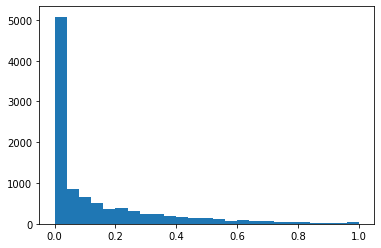

In [24]:
plt.hist(hey['ratio'], bins=25)
plt.show()

In [25]:
cus_info2 = pd.read_csv('cus_info2.csv')

In [26]:
df5['daytrader'] = 1

In [27]:
df = pd.merge(df5, cus_info2, on= ['cus_id'],how='outer')[['cus_id','sex','age_cat','covid','daytrader','grade']]

In [28]:
df = df.fillna(0)

In [29]:
df4 = df.groupby(['age_cat','grade']).count().reset_index()
df2 = df[df['daytrader']==1]
df3 = df2.groupby(['age_cat','grade']).count().reset_index()
df4 = pd.merge(df4,df3,on=['age_cat','grade'],how='outer')

In [30]:
df4 = df4.fillna(0)
df4['ratio'] = df4['daytrader_y']/df4['daytrader_x']
df4[['age_cat','grade','ratio']]

,age_cat,grade,ratio
0,10대 미만,03 로얄,0.14
1,10대 미만,04 그린,0.09
2,10대 미만,05 블루,0.04
3,10대 미만,09 등급없음,0.05
4,20대,01 탑클래스,0.67
5,20대,02 골드,0.00
6,20대,03 로얄,0.27
7,20대,04 그린,0.34
8,20대,05 블루,0.34
9,20대,09 등급없음,0.33


In [31]:
cus_info = df4

#고객별 상품 개수 시각화
df2 = cus_info.loc[cus_info['age_cat'] == '20대']
df3 = cus_info.loc[cus_info['age_cat'] == '30대']
df4 = cus_info.loc[cus_info['age_cat'] == '40대']
df5 = cus_info.loc[cus_info['age_cat'] == '50대']
df6 = cus_info.loc[cus_info['age_cat'] == '60대']
df7 = cus_info.loc[cus_info['age_cat'] == '70대 이상']

trace3 = go.Bar(x=df2.grade, y=df2.ratio, name='20대',marker_color=col[0])
trace4 = go.Bar(x=df3.grade, y=df3.ratio, name='30대',marker_color=col[1])
trace5 = go.Bar(x=df4.grade, y=df4.ratio, name='40대',marker_color=col[2])
trace6 = go.Bar(x=df5.grade, y=df5.ratio, name='50대',marker_color=col[3])
trace7 = go.Bar(x=df6.grade, y=df6.ratio, name='60대',marker_color=col[4])
trace8 = go.Bar(x=df7.grade, y=df7.ratio, name='70대 이상',marker_color=col[5])

fig = go.Figure(data=[trace3, trace4, trace5, trace6, trace7,trace8])
fig.update_layout(title='Day Trader 비율',font=dict(size=18,))
pyo.iplot(fig)

In [32]:
df = df.loc[(df['age_cat']=='20대') | (df['age_cat']=='30대')]

In [33]:
df4 = df.groupby(['age_cat','sex','covid']).count().reset_index()

In [34]:
df2 = df[df['daytrader']==1]
df3 = df2.groupby(['age_cat','sex','covid']).count().reset_index()

In [35]:
df3['ratio'] = df3['daytrader']/df4['daytrader']

In [36]:
df4 = df.groupby(['age_cat','sex','covid']).count().reset_index()

In [37]:
#고객별 종목 산업 개수 시각화

trace3 = go.Bar(x=['코로나 이전','코로나 이후'], y=[0.36,0.36], name='20대 남성',marker_color='#F3BE50')
trace4 = go.Bar(x=['코로나 이전','코로나 이후'], y=[0.27,0.28], name='20대 여성',marker_color='#2C66B5')
trace5 = go.Bar(x=['코로나 이전','코로나 이후'], y=[0.30,0.39], name='30대 남성',marker_color='#F3BE50')
trace6 = go.Bar(x=['코로나 이전','코로나 이후'], y=[0.21,0.28], name='30대 여성',marker_color='#2C66B5')

fig = go.Figure(data=[trace3, trace4, trace5, trace6], layout=go.Layout(title='Day Trader 비율'))
fig.update_layout(font=dict(size=18,))
pyo.iplot(fig)

In [38]:
df = pd.merge(hey,cus_info2,on='cus_id')

In [39]:
import plotly.express as px
import statsmodels.api as sm
# imports
import plotly.graph_objects as go
import numpy as np
from plotly.subplots import make_subplots
df = df.loc[(0<df['freq'])&(df['freq']<2000)]
regline = sm.OLS(df['freq'],sm.add_constant(df['ratio'])).fit().fittedvalues
fig = px.scatter( df,x = 'ratio' ,y = 'freq', color = 'grade',color_discrete_sequence=col,
                 category_orders={"grade":['01 탑클래스','02 골드','03 로얄','04 그린','05 블루','09 등급없음']},
                labels={
                      "freq": "거래 빈도", 
                      "ratio": "Day-Trading 비율",
                      "grade": "고객 등급"
                     })
    
# add linear regression line for whole sample
fig.add_traces(go.Scatter(x=df['ratio'], y=regline,
                          mode = 'lines',
                          marker_color='black'),
                          )
fig.update_layout(title='고객별 상품 개수',font=dict(size=18,))
fig.show()